<a href="https://colab.research.google.com/github/kumastry/cs_stress_majorization/blob/main/%E3%82%B3%E3%83%B3%E3%83%94%E3%83%A5%E3%83%BC%E3%82%BF%E7%A7%91%E5%AD%A6%E7%89%B9%E8%AB%961.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -o graph.zip https://esa-storage-tokyo.s3-ap-northeast-1.amazonaws.com/uploads/production/attachments/8704/2022/06/24/28750/8be3d27d-7c30-471a-a609-ce2ed4ba50fc.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  214k  100  214k    0     0   521k      0 --:--:-- --:--:-- --:--:--  520k


In [ ]:
!mkdir -p result

In [ ]:
!unzip -o graph.zip

Archive:  graph.zip
  inflating: graph/1138_bus.json     
  inflating: graph/3elt.json         
  inflating: graph/bull.json         
  inflating: graph/chvatal.json      
  inflating: graph/cubical.json      
  inflating: graph/davis_southern_women.json  
  inflating: graph/desargues.json    
  inflating: graph/diamond.json      
  inflating: graph/dodecahedral.json  
  inflating: graph/dwt_1005.json     
  inflating: graph/dwt_2680.json     
  inflating: graph/florentine_families.json  
  inflating: graph/frucht.json       
  inflating: graph/heawood.json      
  inflating: graph/hoffman_singleton.json  
  inflating: graph/house.json        
  inflating: graph/house_x.json      
  inflating: graph/icosahedral.json  
  inflating: graph/karate_club.json  
  inflating: graph/krackhardt_kite.json  
  inflating: graph/les_miserables.json  
  inflating: graph/moebius_kantor.json  
  inflating: graph/octahedral.json   
  inflating: graph/pappus.json       
  inflating: graph/petersen.json  

In [ ]:
UNIT_EDGE_LENGTH = 30

In [ ]:
import glob
import json
import os.path
import pandas as pd
import networkx as nx
records = []
for filename in glob.glob('graph/*.json'):
    graph = nx.node_link_graph(json.load(open(filename)))
    records.append([
        os.path.basename(filename),
        graph.number_of_nodes(),
        graph.number_of_edges(),
        nx.is_connected(graph),
    ])
df = pd.DataFrame(records, columns=['filename', 'number_of_nodes', 'number_of_edges', 'is_connected'])
df

,filename,number_of_nodes,number_of_edges,is_connected
0,USpowerGrid.json,4941,6594,True
1,house.json,5,6,True
2,tutte.json,46,69,True
3,house_x.json,5,8,True
4,dwt_1005.json,1005,3808,True
5,pappus.json,18,27,True
6,petersen.json,10,15,True
7,chvatal.json,12,24,True
8,hoffman_singleton.json,50,175,True
9,heawood.json,14,21,True


In [ ]:
from math import sqrt
from random import random
from networkx import floyd_warshall_numpy
from scipy.sparse.linalg import cg
import numpy as np

def inv(x):
    if x < 1e-4:
        return 0.0
    return 1 / x


def stress(X, D):
    n = len(X)
    s = 0
    for i in range(n):
        X_i = X[i, :]
        for j in range(i):
            X_j = X[j, :]
            d = np.linalg.norm(X_i - X_j) - D[i, j]
            s += d * d
    return s



def stress_majorization(graph):
    epsilon = 1e-4
    n = graph.number_of_nodes()
    D = floyd_warshall_numpy(graph)
    print(D)
    w = np.zeros((n, n))
    delta = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            w[i, j] = w[j, i] = D[i, j] ** -2
            delta[i, j] = delta[j, i] = w[i, j] * D[i, j]
    Z = np.random.rand(n, 2)
    Z[0] = (0., 0.)
    L_w = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            L_w[i, j] = L_w[j, i] = -w[i, j]
    for i in range(n):
        L_w[i, i] = -sum(L_w[i, :])
    e0 = stress(Z, D)
    while True:
        L_Z = np.zeros((n, n))
        for i in range(n):
            Z_i = Z[i, :]
            for j in range(i):
                Z_j = Z[j, :]
                L_Z[i, j] = L_Z[j, i] = -delta[i, j] * inv(np.linalg.norm(Z_i - Z_j))
        for i in range(n):
            L_Z[i][i] = -sum(L_Z[i, :])
        Z[1:, 0] = cg(L_w[1:, 1:], (L_Z @ Z[:, 0])[1:])[0]
        Z[1:, 1] = cg(L_w[1:, 1:], (L_Z @ Z[:, 1])[1:])[0]
        e = stress(Z, D)
        if (e0 - e) / e0 < epsilon:
            break
        e0 = e
    return {u: Z[i] for i, u in enumerate(graph.nodes())}

In [ ]:
import random
import numpy as np
import math

def floyd_warshall_dij(graph):
  print("floyd start")
  idx = 0
  label_dict = {}
  for u in graph.nodes:
    label_dict[u] = idx
    idx += 1

  dij = []
  shortest_path_dict  = nx.floyd_warshall(graph)
  max_d = -1
  for i , dics in shortest_path_dict.items():
    vec = [0] * len(graph.nodes)
    for dic in dics.items():
      vec[label_dict[dic[0]]] = dic[1]
      max_d = max(max_d, dic[1])
    dij.append(vec)
  print("floyd end")
  return dij, max_d

def SGD(graph):
  n = graph.number_of_nodes()
  k = 2
  d, max_d = floyd_warshall_dij(graph)
  print(max_d)

  X = np.ones((n, k))
  size = UNIT_EDGE_LENGTH * graph.number_of_nodes() ** 0.5
  for i in range(n):
    for j in range(k):
      X[i][j] =   random.random() * size

  eta = 1000
  lamda = 0.8
  tmax = 15
  EPS = 0.1

  ordered_each = []

  for i in range(n):
    for j in range(i+1, n):
      ordered_each.append((i, j))

  for t in range(tmax):
    random.shuffle(  ordered_each )
    for i,j in ordered_each:
      wij  = d[i][j] ** -2
      mu = min(eta*wij, 1)
      nodes_norm = np.linalg.norm(X[i]-X[j])
      r = ( nodes_norm  -   d[i][j])  /  2.0  / nodes_norm * (X[i] - X[j])
      X[i] -= mu * r
      X[j] += mu * r
    eta = (max_d **2 ) *  math.exp(-lamda*t)
    eta = max(eta, EPS)
    print(t, eta)
    # print(eta)
    # print(X)
  return  { u : (v[0], v[1])  for (u, v) in zip(graph.nodes , X) }

In [ ]:
import random
import itertools

def MaxMinRandomSP(graph, h):
  graph_nodes = [  i for i in graph.nodes]
  source = random.choice(graph_nodes)

  pivots  = [source]
  for i in range(h-1):
    p = nx.shortest_path_length(graph, source=source)
    max_len = -1
    pivot = -1
    for target in graph.nodes:
      if(p[target] > max_len and not ( target in set(pivots))):
        max_len = p[target]
        pivot = target
    pivots.append(pivot)
    source = pivot
  return pivots

def  SparseShortestPaths(graph, pivots):
  n = graph.number_of_nodes()
  d = [[-1] * (n) for _ in range(n)]
  for source in pivots:
    p = nx.shortest_path_length(graph, source=source)
    for target in graph.nodes:
      if(not p[target]):
         pass
      d[source-1][target-1] = p[target]
      d[target-1][source-1] = p[target]
  print(d[0][0])
  return d

def  RandomMatrix(n, k):
  X = np.ones((n, k))
  size = UNIT_EDGE_LENGTH * graph.number_of_nodes() ** 0.5
  for i in range(n):
    for j in range(k):
      X[i][j] =   random.random() * size
  return X

def Make_order_each(pivots, graph):
  ordered_each = list( ( itertools.product(pivots, graph.nodes)) )
  graph_edge_set = set ( itertools.product(pivots, graph.nodes))

  for i, j in graph.edges:
    if((i, j) in graph_edge_set or (j, i) in graph_edge_set):
      pass
    ordered_each.append((i, j))
  return ordered_each
#========================================================================================
def SSGD(graph,  h):
  n = graph.number_of_nodes()
  k = 2
  w =  [[0] * (n) for _ in range(n)]


  pivots = MaxMinRandomSP(graph, h)
  print("finish pivots")
  d  = SparseShortestPaths(graph, pivots)
  print("finishd")
  print(d[0][0])
  graph_edges_set = set(graph.edges)
  for p, i in itertools.product(pivots, graph.nodes):
    if((p, i ) in graph_edges_set or (i , p) in graph_edges_set):
      pass
    s = 5
    w[i-1][p-1] = s*( (d[i-1][p-1] +2)** -2 )
    w[p-1][i-1] = s*(( d[p-1][i-1]+2) ** -2 )

  print("end")

  for i, j in graph.edges:
    w[i-1][j-1] = 1 / 1
    w[j-1][i-1] = 1 / 1

  X = RandomMatrix(n, k)
  ordered_each = Make_order_each(pivots, graph)

  eta = 1000
  max_d = 100
  lamda = 0.8
  tmax = 15
  EPS = 0.1
  tmax = 15
  for t in range(tmax):
    random.shuffle(  ordered_each )
    for i,j in ordered_each:
      i -= 1
      j -= 1

      mu_i = min(1, eta*w[i][j])
      mu_j = min(1, eta*w[j][i])

      nodes_norm = np.linalg.norm(X[i]-X[j])
      r = ( nodes_norm  -   d[i][j])  /  2.0  / nodes_norm * (X[i] - X[j])
      X[i] -= mu_i * r
      X[j] += mu_j * r
    eta = (max_d **2 ) *  math.exp(-lamda*t)
    eta = max(eta, EPS)
    print(t)
  return  { u : (v[0], v[1])  for (u, v) in zip(graph.nodes , X) }

In [ ]:
import json
import networkx as nx
name =  'dwt_1005'
graph = nx.node_link_graph(json.load(open(f'graph/{name}.json')))


pos = SSGD(graph, 5)


finish pivots
-1
finishd
-1
end


<ipython-input-90-e46d19534ec7>:96: RuntimeWarning: invalid value encountered in double_scalars
  r = ( nodes_norm  -   d[i][j])  /  2.0  / nodes_norm * (X[i] - X[j])


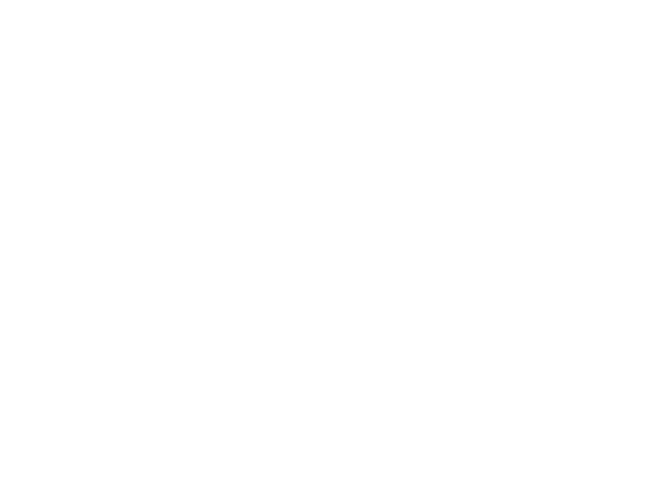

In [ ]:
# 描画結果の表示
nx.draw(graph, pos)

In [ ]:
# 描画結果の評価
import itertools
import math
d = dict(nx.all_pairs_dijkstra_path_length(graph, weight=lambda u, v, e: 30))
s = 0
for u, v in itertools.combinations(graph.nodes, 2):
    s += (math.hypot(pos[u][0] - pos[v][0], pos[u][1] - pos[v][0]) - d[u][v]) ** 2 / d[u][v] ** 2
s

In [ ]:
# 描画結果の保存
json.dump(pos, open(f'result/{name}.json', 'w'))